# Importaciones de librerías

In [17]:
import pandas as pd

from scikitplot.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from src.modeling.utils.utils import print_scores
from src.modeling.utils.utils import drop_dataset_unnecessary_columns
from src.modeling.utils.utils import train_test_model
from src.preparation.data_access.obtained_text_da import ObtainedTextDA

# Constantes

In [18]:
OT_DA = ObtainedTextDA()
TEXTS = OT_DA.select_all_as_dataframe()
TEXTS = TEXTS[TEXTS['category'] == 'Comunicación'].drop(columns=['cluster_grade'])
TEST_SIZE = 0.2
DATA_COLUMNS = [c for c in TEXTS.columns if c not in ['category', 'filename', 'grade', 'id']]
TEXTS

,CNCADC,CNCAdd,CNCAll,CNCCaus,CNCLogic,CNCTemp,CRFANP1,CRFANPa,CRFAO1,CRFAOa,...,WRDPRP1s,WRDPRP2p,WRDPRP2s,WRDPRP3p,WRDPRP3s,WRDVERB,category,filename,grade,id
46,1.814942,0.857973,61.114044,8.183738,47.254488,3.002904,0.069312,0.028033,0.323136,0.082070,...,6.599789,1.253960,2.408923,0.560982,12.902587,113.252376,Comunicación,comunicacion-situaciones-comunicativas-portafo...,1.0,47.0
47,0.388232,0.258821,69.450436,4.874472,57.242688,6.686222,0.092777,0.034539,0.263065,0.056593,...,2.372530,1.639203,4.615650,1.423518,10.999914,94.771806,Comunicación,comunicacion1-cuaderno-trabajo.txt,1.0,48.0
48,1.212191,0.086585,64.130686,7.013392,45.803510,10.015008,0.063739,0.026429,0.209632,0.045644,...,2.308936,0.375202,2.915031,2.366659,8.196721,138.334103,Comunicación,comunicacion2-cuaderno-trabajo.txt,1.0,49.0
49,1.970964,0.096145,62.253629,7.980002,44.611095,7.595424,0.093656,0.046554,0.297281,0.071110,...,3.941929,0.192289,2.884338,2.836266,11.633497,138.400154,Comunicación,comunicacion3-cuaderno-trabajo.txt,1.0,50.0
50,1.026007,0.401481,61.605032,10.929206,43.092296,6.156042,0.077408,0.035984,0.288417,0.067927,...,2.542713,0.133827,4.683945,1.739751,8.654146,118.080029,Comunicación,comunicacion4-cuaderno-trabajo.txt,1.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,10.168675,1.012048,60.096386,15.084337,24.626506,9.204819,0.153777,0.113482,0.229317,0.130330,...,12.144578,2.650602,15.180723,2.409639,20.192771,118.265060,Comunicación,seis_personajes_busca.txt,2.0,179.0
179,8.489796,0.593692,56.653061,15.762523,25.751391,6.055659,0.072211,0.051115,0.170490,0.105130,...,10.241187,0.044527,2.077922,1.128015,9.261596,108.897959,Comunicación,viaje_centro_tierra.txt,2.0,180.0
180,8.669041,0.941620,74.623352,19.456726,40.274707,5.281258,0.328918,0.254774,0.546726,0.382347,...,20.848686,0.194465,0.020470,3.531073,13.745599,114.120200,Comunicación,viajes_gulliver.txt,2.0,181.0
181,4.147928,0.218312,82.958564,22.355150,52.045584,4.191591,0.287313,0.192939,0.375622,0.225790,...,22.879099,0.480286,2.357770,2.969043,22.922761,102.606645,Comunicación,vida_lazarillo_tormes.txt,2.0,182.0


# Todas las categorias

## Preprocesando los datos

In [19]:
X, y = drop_dataset_unnecessary_columns(TEXTS, ['filename', 'category', 'grade', 'id'], 'grade')
X[DATA_COLUMNS] = MinMaxScaler().fit_transform(X[DATA_COLUMNS])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=TEST_SIZE, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 48), (21, 48), (80,), (21,))

## Entrenando los modelos

In [20]:
results = pd.DataFrame()

### Regresión Logística

In [21]:
lr_gs = GridSearchCV(LogisticRegression(verbose=1), param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 10000],
    'random_state': [43]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
lr_gs.fit(X_train, y_train)
lr_gs.best_params_

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


{'C': 10, 'max_iter': 100, 'random_state': 43, 'solver': 'newton-cg', 'tol': 1}

In [22]:
results, y_pred = train_test_model(model=LogisticRegression,
                                   model_name='Logistic Regression',
                                   params=lr_gs.best_params_,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

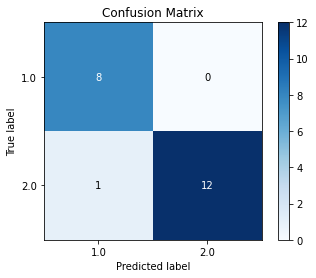

In [23]:
plot_confusion_matrix(y_test, y_pred)

### Máquina de soporte de vectores

In [24]:
svm_gs = GridSearchCV(SVC(verbose=1), param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'random_state': [43],
    'probability': [True]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
svm_gs.fit(X_train, y_train)
svm_gs.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


[LibSVM]

[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished


{'C': 10,
 'gamma': 'scale',
 'kernel': 'rbf',
 'probability': True,
 'random_state': 43,
 'tol': 1e-05}

In [25]:
results, y_pred = train_test_model(model=SVC,
                           model_name='Support Vector Machine',
                           params=svm_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

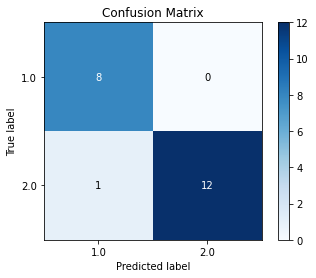

In [26]:
plot_confusion_matrix(y_test, y_pred)

### Árbol de decisión

In [27]:
dtc_gs = GridSearchCV(DecisionTreeClassifier(), param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, None],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [43]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
dtc_gs.fit(X_train, y_train)
dtc_gs.best_params_

Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:    1.9s finished


{'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'random_state': 43,
 'splitter': 'random'}

In [28]:
results, y_pred = train_test_model(model=DecisionTreeClassifier,
                           model_name='Decision Tree',
                           params=dtc_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9047619047619048
The precision score is: 0.8
The recall score is: 1.0
The F1 score is: 0.888888888888889


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

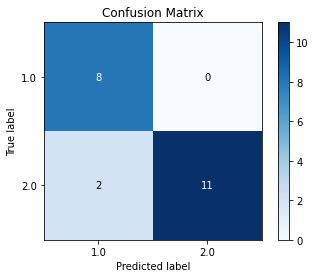

In [29]:
plot_confusion_matrix(y_test, y_pred)

### Bosque aleatorio

In [30]:
rfc_gs = GridSearchCV(RandomForestClassifier(), param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [1, 2, 3, 4, 5, 6 ,7 ,8, 9, 10, None],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [43]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
rfc_gs.fit(X_train, y_train)
rfc_gs.best_params_

Fitting 5 folds for each of 352 candidates, totalling 1760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1760 out of 1760 | elapsed:  2.3min finished


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 50,
 'random_state': 43}

In [31]:
results, y_pred = train_test_model(model=RandomForestClassifier,
                           model_name='Random Forest',
                           params=rfc_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

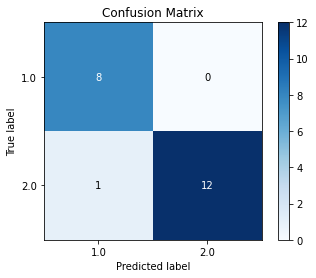

In [32]:
plot_confusion_matrix(y_test, y_pred)

### K Nearest Neighbors

In [33]:
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
knn_gs.fit(X_train, y_train)
knn_gs.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.1s finished


{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

In [34]:
results, y_pred = train_test_model(model=KNeighborsClassifier,
                           model_name='K Nearest Neighbors',
                           params=knn_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

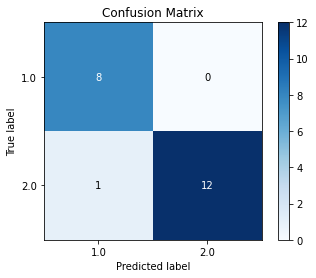

In [35]:
plot_confusion_matrix(y_test, y_pred)

### Perceptron

In [36]:
p_gs = GridSearchCV(Perceptron(), param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    'max_iter': [100, 1000, 10000],
    'tol': [1, 0.1, 0.01, 0.001, 0.0001],
    'early_stopping': [False, True]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
p_gs.fit(X_train, y_train)
p_gs.best_params_

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2100 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    6.7s finished


{'alpha': 0.01,
 'early_stopping': False,
 'max_iter': 100,
 'penalty': 'l2',
 'tol': 0.1}

In [37]:
results, y_pred = train_test_model(model=Perceptron,
                           model_name='Perceptron',
                           params=p_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

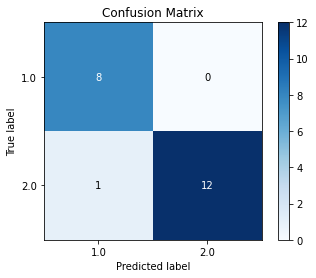

In [38]:
plot_confusion_matrix(y_test, y_pred)

### Ada Boost

In [39]:
ab_gs = GridSearchCV(AdaBoostClassifier(), param_grid = {
    'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [50, 100, 200, 400],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [43]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
ab_gs.fit(X_train, y_train)
ab_gs.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.9s finished


{'algorithm': 'SAMME',
 'learning_rate': 0.01,
 'n_estimators': 50,
 'random_state': 43}

In [40]:
results, y_pred = train_test_model(model=AdaBoostClassifier,
                           model_name='Ada Boost',
                           params=ab_gs.best_params_,
                           X_train=X_train,
                           y_train=y_train,
                           X_test=X_test,
                           y_test=y_test,
                           results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 1.0
The recall score is: 0.875
The F1 score is: 0.9333333333333333


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

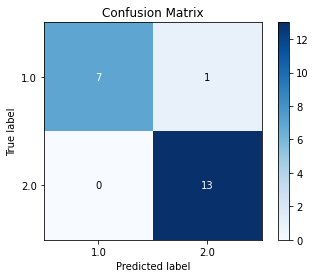

In [41]:
plot_confusion_matrix(y_test, y_pred)

### Gradient Boosting

In [42]:
gb_gs = GridSearchCV(GradientBoostingClassifier(), param_grid = {
    'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [50, 100, 200, 400],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_depth': range(1, 11),
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [43]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
gb_gs.fit(X_train, y_train)
gb_gs.best_params_

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 6352 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7610 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 8560 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 9610 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 10760 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 12010 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 13360 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 14810 tasks   

{'criterion': 'mse',
 'learning_rate': 1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 50,
 'random_state': 43}

In [43]:
results, y_pred = train_test_model(model=GradientBoostingClassifier,
                                   model_name='Gradient Boosting',
                                   params=gb_gs.best_params_,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

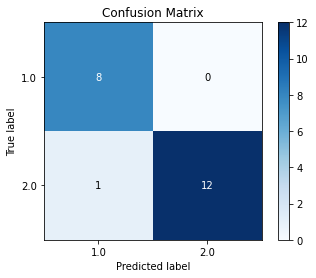

In [44]:
plot_confusion_matrix(y_test, y_pred)

### Voting

In [45]:
v_gs = GridSearchCV(VotingClassifier(estimators=[
    ('lr', LogisticRegression(**lr_gs.best_params_)),
    ('svm', SVC(**svm_gs.best_params_)),
    ('dt', DecisionTreeClassifier(**dtc_gs.best_params_)),
    ('rf', RandomForestClassifier(**rfc_gs.best_params_)),
    ('knn', KNeighborsClassifier(**knn_gs.best_params_)),
    ('ab', AdaBoostClassifier(**ab_gs.best_params_)),
    ('gb', GradientBoostingClassifier(**gb_gs.best_params_))
]), param_grid = {
    'voting': ['soft', 'hard'],
    'flatten_transform': [True, False]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
v_gs.fit(X_train, y_train)
v_gs.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


{'flatten_transform': True, 'voting': 'soft'}

In [46]:
results, y_pred = train_test_model(model=VotingClassifier,
                                   estimators=[
                                                ('lr', LogisticRegression(**lr_gs.best_params_)),
                                                ('svm', SVC(**svm_gs.best_params_)),
                                                ('dt', DecisionTreeClassifier(**dtc_gs.best_params_)),
                                                ('rf', RandomForestClassifier(**rfc_gs.best_params_)),
                                                ('knn', KNeighborsClassifier(**knn_gs.best_params_)),
                                                ('ab', AdaBoostClassifier(**ab_gs.best_params_)),
                                                ('gb', GradientBoostingClassifier(**gb_gs.best_params_))
                                            ],
                                   model_name='Voting',
                                   params=v_gs.best_params_,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

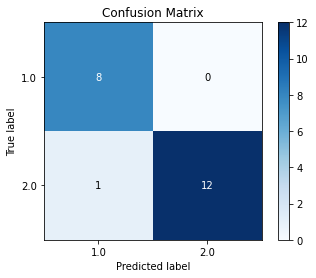

In [47]:
plot_confusion_matrix(y_test, y_pred)

### Stacking

In [48]:
s_gs = GridSearchCV(StackingClassifier(estimators=[
    ('lr', LogisticRegression(**lr_gs.best_params_)),
    ('svm', SVC(**svm_gs.best_params_)),
    ('dt', DecisionTreeClassifier(**dtc_gs.best_params_)),
    ('rf', RandomForestClassifier(**rfc_gs.best_params_)),
    ('knn', KNeighborsClassifier(**knn_gs.best_params_)),
    ('ab', AdaBoostClassifier(**ab_gs.best_params_)),
    ('gb', GradientBoostingClassifier(**gb_gs.best_params_))
]), param_grid = {
    'stack_method': ['auto', 'predict_proba', 'decision_function', 'predict'],
    'passthrough': [True, False]
}, scoring = {
    'Recall': make_scorer(recall_score),
    'Accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score)
}, refit='f1', n_jobs=-1, verbose=1)
s_gs.fit(X_train, y_train)
s_gs.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.2s finished


{'passthrough': True, 'stack_method': 'auto'}

In [49]:
results, y_pred = train_test_model(model=StackingClassifier,
                                   estimators=[
                                                ('lr', LogisticRegression(**lr_gs.best_params_)),
                                                ('svm', SVC(**svm_gs.best_params_)),
                                                ('dt', DecisionTreeClassifier(**dtc_gs.best_params_)),
                                                ('rf', RandomForestClassifier(**rfc_gs.best_params_)),
                                                ('knn', KNeighborsClassifier(**knn_gs.best_params_)),
                                                ('ab', AdaBoostClassifier(**ab_gs.best_params_)),
                                                ('gb', GradientBoostingClassifier(**gb_gs.best_params_))
                                            ],
                                   model_name='Stacking',
                                   params=s_gs.best_params_,
                                   X_train=X_train,
                                   y_train=y_train,
                                   X_test=X_test,
                                   y_test=y_test,
                                   results=results)

The accuracy score is: 0.9523809523809523
The precision score is: 0.8888888888888888
The recall score is: 1.0
The F1 score is: 0.9411764705882353


#### Matriz de confusión

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

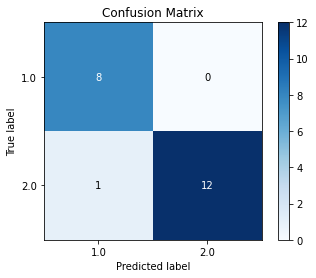

In [50]:
plot_confusion_matrix(y_test, y_pred)

## Resultados

In [51]:
results['Promedio'] = results.mean(axis=1)
results

,accuracy,precision,recall,f1 score,Promedio
Logistic Regression,0.952381,0.888889,1.000,0.941176,0.945612
Support Vector Machine,0.952381,0.888889,1.000,0.941176,0.945612
Decision Tree,0.904762,0.800000,1.000,0.888889,0.898413
Random Forest,0.952381,0.888889,1.000,0.941176,0.945612
K Nearest Neighbors,0.952381,0.888889,1.000,0.941176,0.945612
Perceptron,0.952381,0.888889,1.000,0.941176,0.945612
Ada Boost,0.952381,1.000000,0.875,0.933333,0.940179
Gradient Boosting,0.952381,0.888889,1.000,0.941176,0.945612
Voting,0.952381,0.888889,1.000,0.941176,0.945612
Stacking,0.952381,0.888889,1.000,0.941176,0.945612
